In [1]:
import cv2
from time import sleep
import numpy as np
from sklearn.cluster import KMeans
import requests
import matplotlib.pyplot as plt

import os

For a image matching task, note that in the previous courses we extract local features (i.e. SIFT) on some interest points and performs a least-distance matching. However, consider a database of $N$ images, performing such matching takes at least $O(N)$ times. 

In [2]:
sift = cv2.SIFT_create()

def make_dataset(N=100, load_dir=None, save_dir=None):
    """ N: the number of images for the dataset
        return a database of N images and their keypoints and descriptors 
    """
    images = []
    keypoints = []
    descriptors = []
    
    if load_dir:
        for path in os.listdir(load_dir):
            image = cv2.imread(os.path.join(load_dir, path))
            kps, des = sift.detectAndCompute(image, None)
            images.append(image)
            keypoints.append(kps)
            descriptors.append(des)
        return images, keypoints, descriptors
    
    # https://picsum.photos/ will return random images 
    url = "https://picsum.photos/200/"
    for i in range(N):
        kps = None
        while not kps:
            image = np.asarray(bytearray(requests.get(url).content), dtype="uint8")
            image = cv2.imdecode(image, cv2.IMREAD_COLOR)
            kps, des = sift.detectAndCompute(image, None)
            print(len(kps))
        if save_dir:
                cv2.imwrite(os.path.join(save_dir, f"{i}.png"), image)
        images.append(image)
        keypoints.append(kps)
        descriptors.append(des)
    return images, keypoints, descriptors

In [3]:
images, kps, descriptors = make_dataset(50)

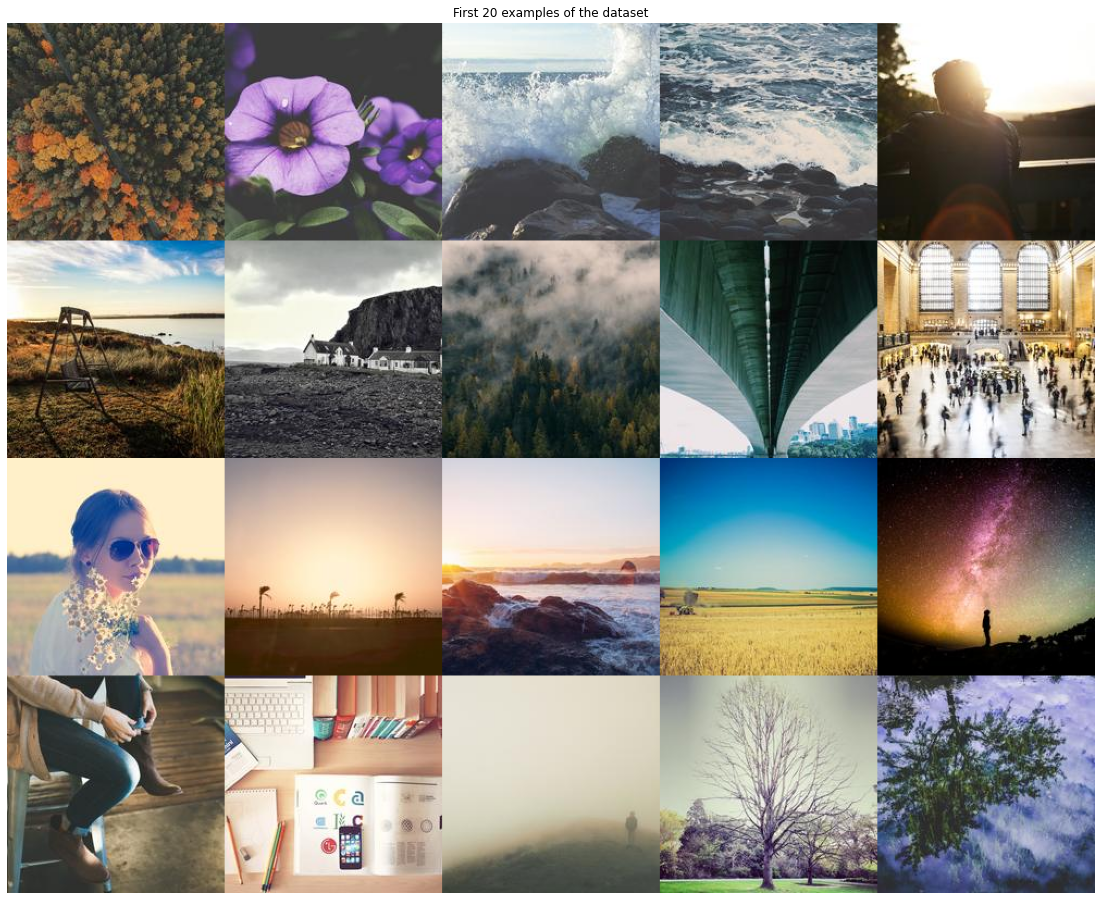

In [4]:
first_20_images = np.vstack([
    np.hstack(images[0:5]), 
    np.hstack(images[5:10]), 
    np.hstack(images[10:15]),
    np.hstack(images[15:20])
])
plt.figure(figsize=(20, 16))
plt.imshow(cv2.cvtColor(first_20_images, cv2.COLOR_BGR2RGB))
plt.axis("off"); plt.title("First 20 examples of the dataset");

Consider a text documents, an efficient way of find all pages is to use an index, we can build a similar index on the images. 

For a database of images $\mathcal D = \{I_1,..., I_N\}$,  
each image $I_i$ has a set of $m_i$ interest points and their corresponding $D$-dim descriptors $(\mathcal P_i \subseteq \mathbb R^{2\times m_i}, \mathcal F_i \subseteq \mathbb R^{D\times m})$. In SIFT case, $D = 128$. 

# Visual Words
One natural way is to use the descriptors as our visual word, while we have $N\times m$ (assuming each image has $m$ descriptors) different vectors. In order to construct a dictionary of visual words, we perform some kinds of clustering algorithm on all the descriptors. One easy algorithm will be __k-means__ (see CSC311 notes for more details). The $k$ cluster centers will then be the dictionary and we assign each descriptor $f$ to one of the cluster centers $\{W_1, ..., W_k\}$ by $\arg\min_i\|f- W_i\|$.

In [5]:
k = 100
def construct_visual_dictionary(descriptors, k):
    """ descriptors: a list of m_i * D descriptors
        k:           int, size of the dictionary
        returns a a list where ith element is the words of the ith image
        and the kmeans object
    """
    descriptors_stack = np.vstack(descriptors)
    kmeans  = KMeans(n_clusters=k).fit(descriptors_stack)
    labels = kmeans.labels_
    image_labels = []
    row = 0
    for i, image_descriptors in enumerate(descriptors):
        image_labels.append(labels[row: row + image_descriptors.shape[0]])
        row += image_descriptors.shape[0]
    return image_labels, kmeans

img_words, kmeans = construct_visual_dictionary(descriptors, k)

# Inverted File Index
Now, each image is assigned with a number of words. As a book index do, for each word $W_i$, we construct an inverted index $\{I\in\mathcal D\mid W_i\in I\}$

In [6]:
def inverted_file_index(image_labels, k):
    """ 
        returns a list of set where ith element is the
        set of documents that has the word i
    """
    dictionary = []
    for _ in range(k):
        dictionary.append(set())
    for image, labels in enumerate(image_labels):
        for word in labels:
            dictionary[word].add(image)
    return dictionary
dictionary = inverted_file_index(img_words, k)

# Bag of Words
Now we are retrieve the query image by checking all images in the database that have at least one visual word in common. However, this can still be too large. We need some measurement of similarity between query image and retrieved images. Then just match query to top $K$ most similar images. 

Then, to define "similarity", we consider the distribution of word occurrences within the images. However, if one word appears in many images and has a big count in each image, the similarity will be dominated by it. Therefore, for each image, we make an image description vector with __term frequency-inverse document frequency__
$$\mathbf t = [t_1, t_2,..., t_k], t_i = \frac{n_{id}}{n_d}\log(\frac{N}{n_i})$$
where $n_{id}$ is the number of occurrences of word $i$ in image $d$,  
$n_d$ is the number of words in image $d$ and  
$n_i$ is the number of occurrence of word $i$ in database,  
$N$ is the total number of images in the whole database

Then, the similarity between two images $t_i, t_j$ is measure as 
$$sim(t_i, t_j) = \frac{t_i\cdot t_j}{\|t_i\|\|t_j\|}$$
Then, we can choose top $K$ best ranked images and do spatial verification (RANSAC match transformation matrix). 

In [7]:
def compute_tfidf(img_words, k):
    """ returns a 2D image description vertor where 
        ith row is a tfidf vector t_i
    """
    N = len(img_words)
    t = np.zeros((N, k))
    for i, words in enumerate(img_words):
        for d in words:
            t[i, d] += 1
    nd = np.sum(t, axis=1)[:, None]
    ni = np.sum(t, axis=0)[None, :]
    return t / nd * np.log(N / ni)

t = compute_tfidf(img_words, k)

In [8]:
def sim(t, i, K):
    """ given the tfidf matrix t, find the similarity of 
        t_i against all other's and return the top K similar 
        ones
    """
    t_i = t[i][:, None]
    norms = np.linalg.norm(t, axis=1)
    sim = (t @ t_i) / ((norms * norms[i])[:, None])
    return sim.argsort(axis=0)[::-1][1:K+1].reshape(K)

In [9]:
def find_candidates(kp_q, des_q, kmeans, dictionary, K):
    """ make a query given the query image, the 
        inverted file index dictionary, 
        the kmeans object, and 
        returns the top K similar image's index
    """
    k = len(kmeans.cluster_centers_)
    query_words = kmeans.predict(des_q)
    word_set = set(query_words)
    candidates = set()
    for word in word_set:
        candidates |= dictionary[word]
    candidates = list(candidates)
    cand_img_words = [query_words]
    for cand_idx in candidates:
        cand_img_words.append(img_words[cand_idx])
    tfitf = compute_tfidf(cand_img_words, k)
    similarity = sim(tfitf, 0, K)
    top_K = []
    for i in similarity:
        top_K.append(candidates[i-1])
    return top_K

In [10]:
def test_match(img1, img2, kp1, des1, kp2, des2):
    """ Feature Matching + Homography according to 
        https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/
        py_feature2d/py_feature_homography/py_feature_homography.html
        Input the keypoints and descriptors of the query image and the 
        test image, return the matching demo image
    """
    FLANN_INDEX_KDTREE = 0
    MIN_MATCH_COUNT = 10
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    return cv2.drawMatches(img1,kp1,img2,kp2,good,None)

In [13]:
# we make some transformation on an arbitray image in the database
# and see if we can find it back
rand_idx = np.random.randint(0, len(images))
query_image = images[rand_idx]
points2 = np.float32([[10,20], [199,10], [10,179], [180,150]])
points1 = np.float32([[0,0], [199,0], [10,199], [199,199]])
M = cv2.getPerspectiveTransform(points1, points2)
query_image = cv2.warpPerspective(query_image,M,(200, 200));

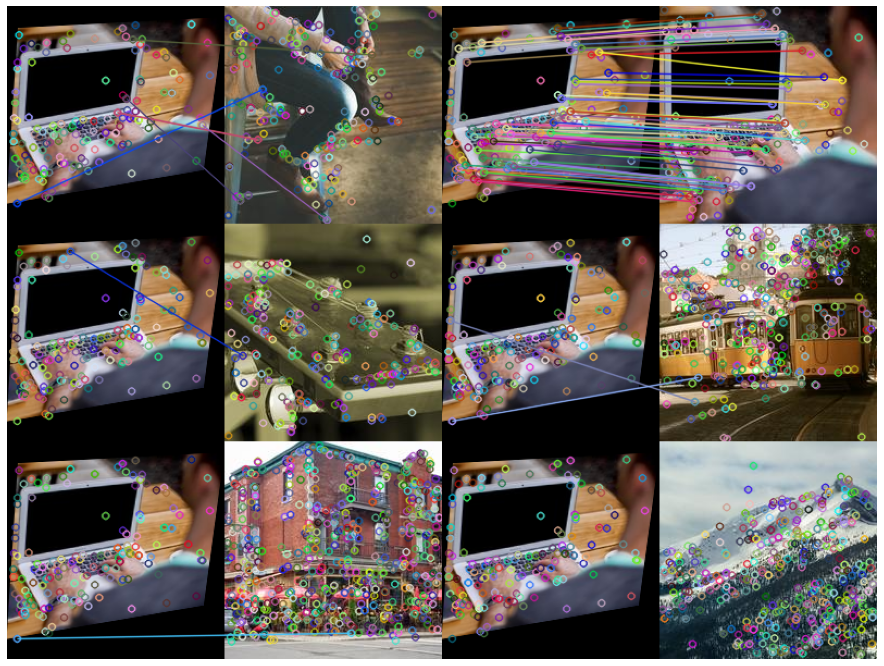

In [14]:
kp_q, des_q = sift.detectAndCompute(query_image, None)
db_candidates = find_candidates(kp_q, des_q, kmeans, dictionary, 6)
demo = None
for i in range(0, len(db_candidates), 2):
    cand = db_candidates[i]
    matching_col_1 = test_match(query_image, images[cand], 
                                kp_q, des_q, 
                                kps[cand], descriptors[cand])
    print
    try:
        cand = db_candidates[i + 1]
        matching_col_2 = test_match(query_image, images[cand], 
                                    kp_q, des_q, 
                                    kps[cand], descriptors[cand])
    except IndexError:
        mathching_col_2 = np.zeros(query_image.shape)
    if demo is None:
        demo = np.hstack((matching_col_1, matching_col_2))
    else:
        demo = np.vstack((demo, np.hstack((matching_col_1, matching_col_2))))
plt.figure(figsize=(16, 12)); plt.axis("off")
plt.imshow(cv2.cvtColor(demo, cv2.COLOR_BGR2RGB));

# Vocabulary Tree

To further improve the speed, we can use a hierarchical clustering for the words. For example, we can do a kMeans clustering on all the vectors first, then for each cluster, we run kMeans on the vectors that belongs to the cluster, and we can recursively do so. When querying, we do the same thing, i.e. predict the clustering, then go to the next level kmeans.